<a href="https://colab.research.google.com/github/sekartalok/C-/blob/main/trainingmulti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import tensorflow as tf

def load_and_prepare_data(npz_path='/content/drive/MyDrive/data_augmented.npz', batch_size=128):

    data = np.load(npz_path)

    train_images = data['train_images']
    train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']


    train_images = train_images.astype(np.float32) / 255.0
    val_images = val_images.astype(np.float32) / 255.0


    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))


    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, validation_dataset




In [11]:
train_dataset, validation_dataset=load_and_prepare_data()

In [30]:
SHUFFLE_BUFFER_SIZE = 128
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )


Image batch shape: (128, 120, 120, 3)
Label batch shape: (128, 9)


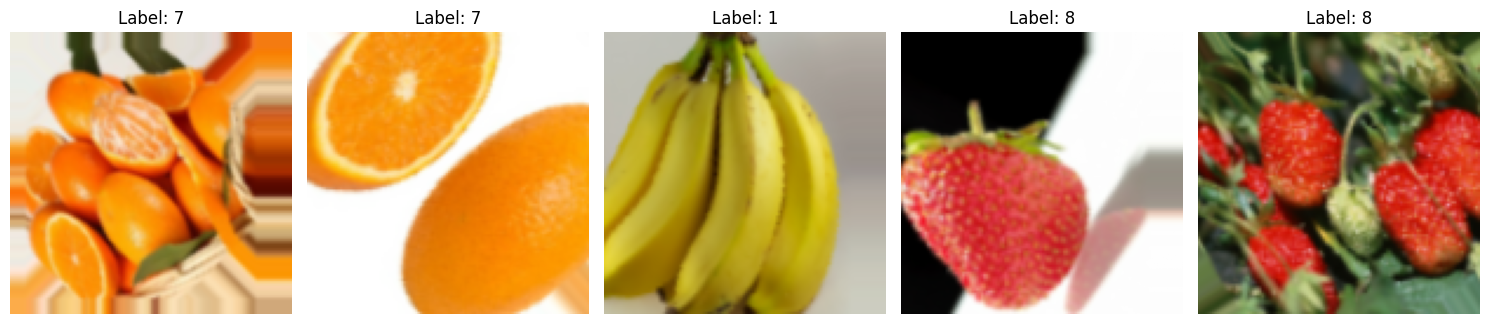

In [28]:


def display_samples(dataset, num_samples=5):
    # Create an iterator from the dataset
    dataset_iterator = dataset.as_numpy_iterator()

    # Get the first batch of images and labels
    images, labels = next(dataset_iterator)

    # Check the shape of the images and labels
    print("Image batch shape:", images.shape)  # Debugging line to check shape
    print("Label batch shape:", labels.shape)  # Debugging line to check shape

    # Ensure you only take the first num_samples from the batch
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Set up the plot
    plt.figure(figsize=(15, 5))

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)  # Create a subplot for each sample
        plt.imshow(images[i])  # Display the image
        plt.title(f'Label: {np.argmax(labels[i])}')  # Display the label (assuming one-hot encoding)
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Example usage to display training and validation samples
display_samples(train_dataset, num_samples=5)        # Display training samples



In [18]:
# Define the model
def create_model(num_classes=9):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(120, 120, 3)),
        tf.keras.layers.Conv2D(10, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(750, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model




In [19]:
model = create_model()

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 118, 118, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 59, 59, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 57, 57, 32)          │           2,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      11,076,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 750)                 │         768,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 750)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           6,759 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,873,805 (45.29 MB)

 Trainable params: 11,873,805 (45.29 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs={}):

        if logs.get('accuracy', 0) >= 0.8 and logs.get('val_accuracy', 0) >= 0.8:
          self.model.stop_training = True

          print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")

In [31]:
history = model.fit(
	train_dataset_final,
	epochs=3,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.3288 - loss: 2.1031 - val_accuracy: 0.2130 - val_loss: 2.1522
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2946 - loss: 2.1122 - val_accuracy: 0.1944 - val_loss: 2.1330
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.3696 - loss: 2.0602 - val_accuracy: 0.1852 - val_loss: 2.1203


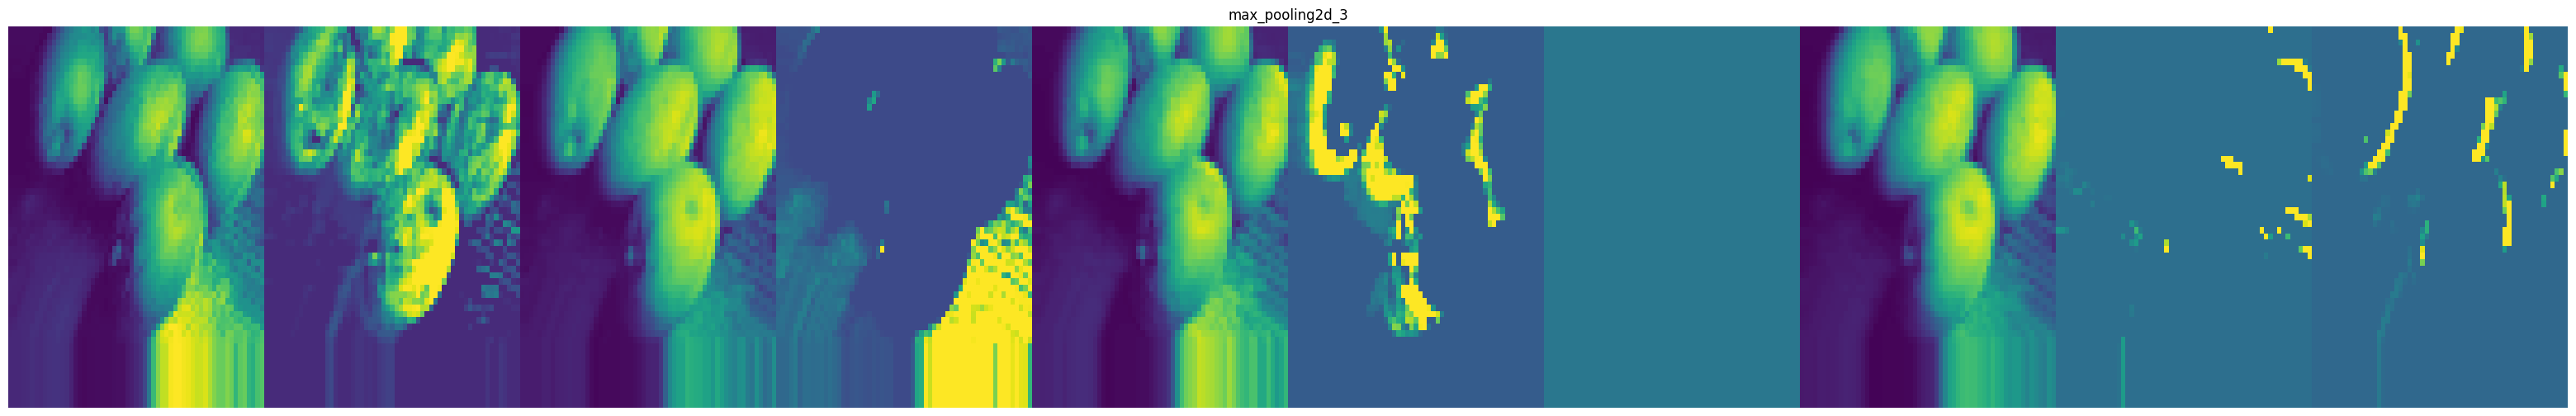

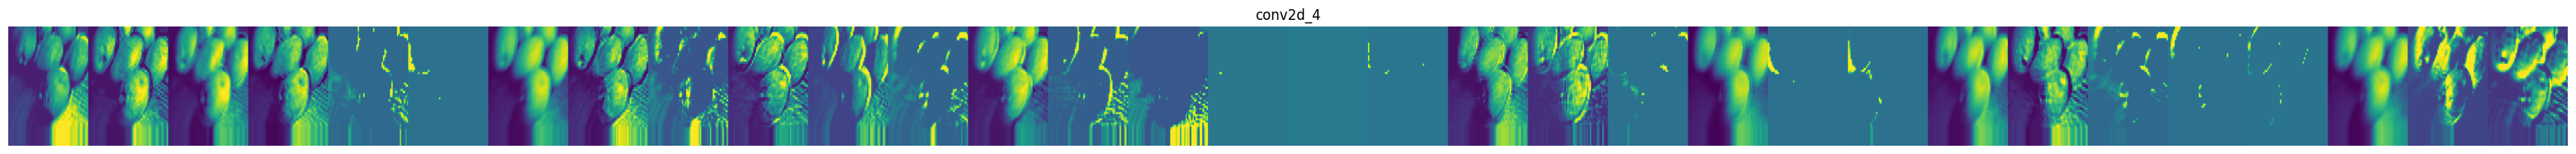

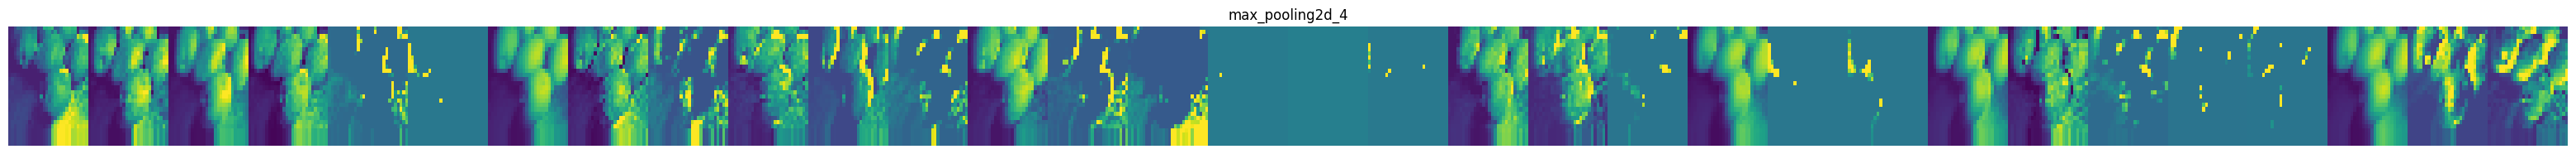

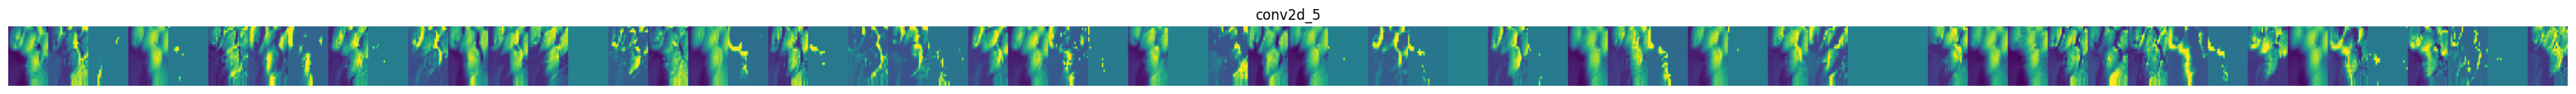

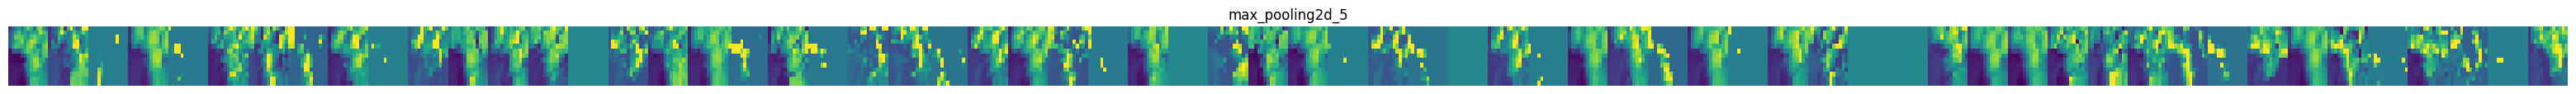

In [34]:
def load_image_from_npz(npz_path, index):
    """Loads an image from the specified .npz file."""
    # Load the .npz file
    data = np.load(npz_path)

    # Access the images
    images = data['train_images']  # Assuming you're using training images
    return images[index]  # Return the image at the specified index

def visualize_intermediate_layers(model, img_array, rescale_layer=None):
    """
    Visualizes the intermediate feature maps of a Keras model for a given input image array.

    Parameters:
    - model: Keras model to visualize.
    - img_array: Numpy array of the input image with shape (height, width, channels).
    - rescale_layer: Optional Keras layer to apply for rescaling the image.
    """

    # Define a new Model that will output intermediate representations
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = tf.keras.models.Model(inputs=model.inputs, outputs=successive_outputs)

    # Reshape the image to add the batch dimension
    x = img_array.reshape((1,) + img_array.shape)  # Shape should be (1, height, width, channels)

    # Optionally scale the image
    if rescale_layer is not None:
        x = rescale_layer(x)

    # Obtain intermediate representations for the input image
    successive_feature_maps = visualization_model.predict(x, verbose=False)

    # Get layer names for visualization
    layer_names = [layer.name for layer in model.layers[1:]]

    # Display the feature maps
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:
            n_features = feature_map.shape[-1]  # Number of features in the feature map
            size = feature_map.shape[1]  # Feature map size

            # Create a grid to tile the feature maps
            display_grid = np.zeros((size, size * n_features))
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std() if x.std() > 0 else 1  # Avoid division by zero
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')

                # Tile each filter into the grid
                display_grid[:, i * size:(i + 1) * size] = x

            # Adjust the figure size for better visibility
            scale = 40. / n_features  # Increase scale to make images larger
            plt.figure(figsize=(scale * n_features, scale * 1.5))  # Adjust height for better visibility
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.axis('off')  # Hide axis
            plt.show()


# Example Usage
npz_path = '/content/drive/MyDrive/data_augmented.npz'
image_index = 8  # Specify the index of the image you want to visualize

# Load the image from the .npz file
img = load_image_from_npz(npz_path, image_index)

# Ensure img is a 3D array (height, width, channels)
if img.ndim == 3:
    # Optionally define a rescale layer (if your model expects scaled inputs)
    rescale_layer = tf.keras.layers.Rescaling(1./255)  # Normalizing to [0, 1]

    # Call the visualization function
    visualize_intermediate_layers(model, img, rescale_layer=rescale_layer)
else:
    print("Error: Loaded image does not have the correct shape.")


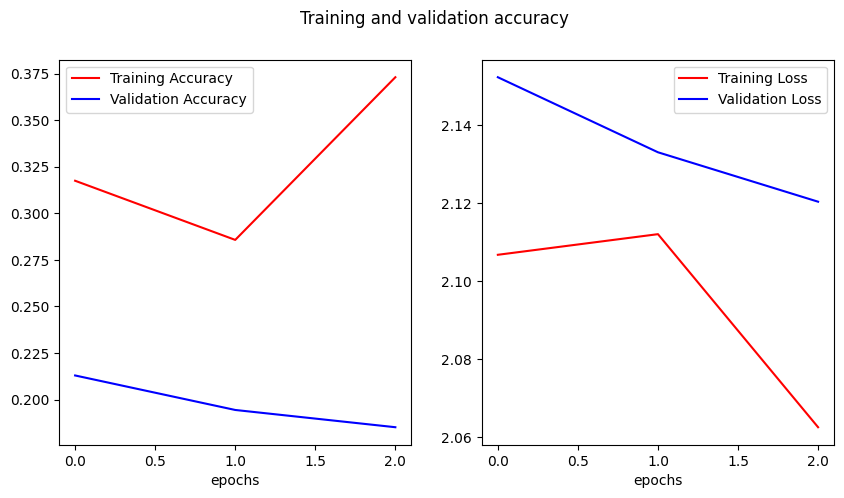

In [35]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()